## Paso 0. Library import

In [ ]:
!pip install flopy

In [1]:
# Temporal, para agregar las rutas correctas
%run ../../src/ft1D/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 

In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import flopy
from flopy.plot.styles import styles
import xmf6
from flow_1D import build_gwf_1D
# Funciones para cálculo de la solución analítica
from wexler1 import sol_analytical_t
# Definición de parámetros de decaimiento y sorción
from sorption_decay import *


<img src="../figures/flow_mf6.png">

* El modelo de malla consiste de 1 capa, 120 columnas y 1 renglón.
* La longitud del renglón es de 12 [cm].
* La longitud de la columna es 0.1 [cm].
* Con la información anterior se calcula el ancho del renglón, DELC, y de las columnas, DELR, que ambos casos debe ser 0.1 $cm$.
* La parte superior (TOP) de la celda es 1.0 [cm] y la parte inferior (BOTTOM) es cero.
* La longitud de la capa es igual a 1.0 [cm], valor que se calcula de |TOP - BOTTOM|.

**<font color='Green'> [1] Konikow, L. F., Goode, D. J., & Hornberger, G. (1996, January 1). A three-dimensional method-of-characteristics solute-transport model (MOC3D). Water-Resources Investigations Report 96-4267.</font>** https://doi.org/10.3133/wri964267

**<font color='Green'> [2] Eliezer J. Wexler, (1992).
Analytical solutions for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow. U.S. Geological Survey Techniques of Water-Resources Investigations, Book 3, Chapter B7, 190 p.</font>** https://doi.org/10.3133/twri03b7

## Paso 1. Definición de parámetros del problema.

### Parámetros para la discretización del espacio.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Length of system (rows) |12.0| cm | `mesh.row_length` |
|Number of layers |1| | `mesh.nlay` |
|Number of rows |1| | `mesh.nrow` |
|Number of columns |120| | `mesh.ncol` |
|Column width |0.1| cm | `mesh.delr` |
|Row width |0.1| cm | `mesh.delc`|
|Top of the model |1.0| cm | `mesh.top`|
|Layer bottom elevation (cm) |0| cm | `mesh.bottom` |

In [4]:
mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)
xmf6.nice_print(mesh.get_dict(), 'Space discretization')


Space discretization
------------------------------
          row_length = 12.0      
          col_length = 0.1       
          lay_length = 1.0       
                ncol = 120       
                nrow = 1         
                nlay = 1         
                delr = 0.1       
                delc = 0.1       
                dell = 1.0       
                 top = 1.0       
              bottom = 0         


### Parámetros para la discretización del tiempo.

* La simulación consta de un período de estrés que tiene una duración de 120 $s$.
* El período de estrés se divide en 240 pasos de tiempo del mismo tamaño.
  
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Number of stress periods |1| | `tm_par['nper']` |
|Total time |120| s | `tm_par['total_time']` |
|Number of time steps| 240 | | `tm_par['nstp']`|
|Multiplier | 1 | | `tm_par['tsmult']`|

In [5]:
tm_par = dict(
    nper = 1,  # Number of periods
    total_time = 120.0,  # Simulation time ($s$)
    nstp = 240,   # Number of time steps
    tsmult = 1.0  # Multiplier for the length of successive time steps.
)
xmf6.nice_print(tm_par, 'Time discretization')


Time discretization
------------------------------
                nper = 1         
          total_time = 120.0     
                nstp = 240       
              tsmult = 1.0       


### Parámetros físicos.

* Al utilizar un valor de porosidad uniforme de 0.1, se obtiene un valor de velocidad de 0.1 $cm/s$ como resultado de la inyección de agua a una velocidad de 0.001 $cm^3/s$ en la primera celda.
* A la última celda se le asigna una carga constante con un valor de cero, aunque este valor no es importante ya que las celdas están marcadas como confinadas.
* A la concentración del agua inyectada se le asigna un valor de 1.0, y cualquier agua que salga a través de la celda de carga constante sale con la concentración simulada del agua en esa última celda.
* La advección se resuelve utilizando el esquema TVD para reducir la dispersión numérica.
  
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Specific discharge |0.1| cm s$^{-1}$ | `ph_par['specific_discharge']` |
|Hydraulic conductivity |0.01| cm s$^{-1}$ | `ph_par['hydraulic_conductivity']` |
|Source concentration |1.0| unitless | `ph_par['source_concentration']` |
|Porosity | 0.1 | unitless |  `ph_par['porosity']` |
|Initial Concentration | 0.0 | unitless | `ph_par['initial_concentration']` |
|Longitudinal Dispersivity | 0.1 |  | `ph_par['longitudinal_dispersivity']` |
|Retardation Factor | 1.0 |  | `ph_par['retardation_factor']` |
|Decay Rate | 0.0 |  | `ph_par['decay_rate']` |
|Dispersion coefficient | | | `ph_par["dispersion_coefficient"]` |

$$
\text{Dispersion Coefficient} = \dfrac{\text{Longitudinal Dispersivity} \times \text{Specific Discharge}}{\text{Retardation Factor}}
$$

In [6]:
ml_units = {
    "time": "seconds",
    "length": "centimeters"
}
xmf6.nice_print(ml_units, 'Units')

ph_par = dict(
    specific_discharge = 0.1,  # Specific discharge ($cm s^{-1}$)
    hydraulic_conductivity = 0.01,  # Hydraulic conductivity ($cm s^{-1}$)
    source_concentration = 1.0,  # Source concentration (unitless)
    porosity = 0.1,  # Porosity of mobile domain (unitless)
    initial_concentration = 0.0,  # Initial concentration (unitless)
    longitudinal_dispersivity = 0.1,
    retardation_factor = 1.0,
    decay_rate =  0.0
)
ph_par["dispersion_coefficient"] = ph_par["longitudinal_dispersivity"] * ph_par["specific_discharge"] / ph_par["retardation_factor"]

xmf6.nice_print(ph_par, 'Physical parameters')


Units
------------------------------
                time = seconds   
              length = centimeters

Physical parameters
------------------------------
  specific_discharge = 0.1       
hydraulic_conductivity = 0.01      
source_concentration = 1.0       
            porosity = 0.1       
initial_concentration = 0.0       
longitudinal_dispersivity = 0.1       
  retardation_factor = 1.0       
          decay_rate = 0.0       
dispersion_coefficient = 0.010000000000000002


## Paso 2. MODFLOW6 environment y salida.

In [7]:
# ----- Definición de Parámetros -----
os_par = dict(
    ws = os.getcwd() + '/output', # Ruta de donde estamos actualmente
    mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6', # Ejecutable
    flow_name = 'flow', # Nombre de la simulación para flujo
    tran_name = 'transport' # Nombre de la simulación para transporte
)
xmf6.nice_print(os_par, 'MODFLOW 6 environment')

oc_par = dict(
    head_file = f"{os_par['flow_name']}.hds",
    fbudget_file = f"{os_par['flow_name']}.bud",
    concentration_file=f"{os_par['tran_name']}.ucn",
    tbudget_file = f"{os_par['tran_name']}.bud",
)
xmf6.nice_print(oc_par, 'Output files')


MODFLOW 6 environment
------------------------------
                  ws = /home/jovyan/GMMC/WMA/notebooks/2_Transporte_mf6_1D/output
             mf6_exe = /home/jovyan/GMMC/WMA/mf6/bin/mf6
           flow_name = flow      
           tran_name = transport 

Output files
------------------------------
           head_file = flow.hds  
        fbudget_file = flow.bud  
  concentration_file = transport.ucn
        tbudget_file = transport.bud


## Paso 3. Solución del flujo (Modelo GWF)

### Resultados del flujo

head_L = 12.899999999999777 	 head_R = 1.0


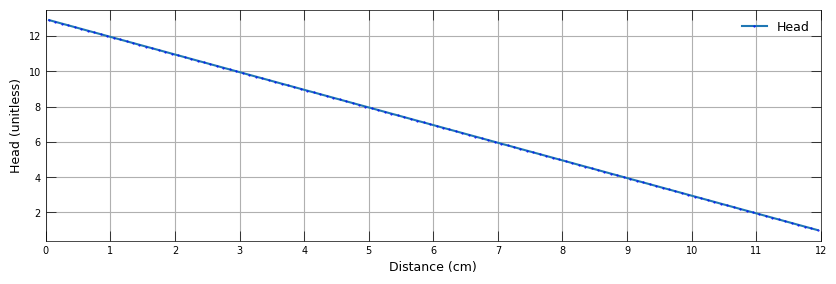

In [8]:
sim_f, gwf = build_gwf_1D(mesh, tm_par, ph_par, ml_units, os_par, oc_par)
sim_f.write_simulation(silent=True)
sim_f.run_simulation(silent=True)
xmf6.plot_flow_1D(gwf, mesh, os_par, oc_par)

### Obtención de arreglos de Numpy para la carga y  la velocidad.

In [9]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(
    os.path.join(os_par['ws'], 
                 oc_par['head_file'])).get_data()
# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(
    os.path.join(os_par['ws'], 
                 oc_par['fbudget_file']),
    precision='double'
)
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [10]:
print(head.shape, '\n', head)

(1, 1, 120) 
 [[[12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8 11.7 11.6
   11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4 10.3 10.2
   10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.   8.9  8.8
    8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6  7.5  7.4
    7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2  6.1  6.
    5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8  4.7  4.6
    4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4  3.3  3.2
    3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.   1.9  1.8
    1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]]]


In [11]:
print(qx.shape, '\n', qx)

(1, 1, 120) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


## Paso 4. Simulation object

In [12]:
sim_t = flopy.mf6.MFSimulation(
    sim_name=os_par["tran_name"], 
    sim_ws=os_par["ws"], 
    exe_name=os_par["mf6_exe"]
)
print(sim_t)

sim_name = transport
sim_path = /home/jovyan/GMMC/WMA/notebooks/2_Transporte_mf6_1D/output
exe_name = /home/jovyan/GMMC/WMA/mf6/bin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = transport





## Paso 5. Time discretization object

In [13]:
flopy.mf6.ModflowTdis(
    sim_t, 
    nper=tm_par["nper"], 
    perioddata=((tm_par["total_time"], 
                 tm_par["nstp"], 
                 tm_par["tsmult"]),),
    time_units=ml_units["time"]
)

package_name = transport.tdis
filename = transport.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = transport

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 240, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i8'), ('tsmult', '<f8')]))



## Paso 6. IMS object (solution calculation)

In [14]:
ims = flopy.mf6.ModflowIms(
    sim_t, 
    linear_acceleration="bicgstab"
)
print(ims)

package_name = ims_-1
filename = transport.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = transport

Block linear
--------------------
linear_acceleration
{internal}
(bicgstab)





## Paso 7. GWT model object (transport)

In [15]:
gwt = flopy.mf6.ModflowGwt(
    sim_t, 
    modelname=os_par["tran_name"], 
    save_flows=True
)
print(gwt)

name = transport
model_type = gwt6
version = mf6
model_relative_path = .




## Paso 8. Space discretization object

In [16]:
dis = flopy.mf6.ModflowGwtdis(
    gwt,
    length_units=ml_units["length"],
    nlay=mesh.nlay,
    nrow=mesh.nrow,
    ncol=mesh.ncol,
    delr=mesh.delr,
    delc=mesh.delc,
    top=mesh.top,
    botm=mesh.bottom,
)

print(dis)

package_name = dis
filename = transport.dis
package_type = dis
model_or_simulation_package = model
model_name = transport

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(120)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





## Paso 9. Initial conditions object

In [17]:
ic = flopy.mf6.ModflowGwtic(
    gwt, 
    strt=0
)
print(ic)

package_name = ic
filename = transport.ic
package_type = ic
model_or_simulation_package = model
model_name = transport

Block griddata
--------------------
strt
{constant 0}





## Paso 10.

In [18]:
mst = flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=ph_par["porosity"],
    **get_sorption_dict(ph_par["retardation_factor"]),
    **get_decay_dict(ph_par["decay_rate"], 
                     ph_par["retardation_factor"] > 1.0),
)

print(mst)

package_name = mst
filename = transport.mst
package_type = mst
model_or_simulation_package = model
model_name = transport

Block griddata
--------------------
porosity
{constant 0.1}





## Paso 11. Advection

In [19]:
adv = flopy.mf6.ModflowGwtadv(
    gwt, 
    scheme="TVD"
)
print(adv)

package_name = adv
filename = transport.adv
package_type = adv
model_or_simulation_package = model
model_name = transport

Block options
--------------------
scheme
{internal}
(tvd)





## Paso 12. 

In [20]:
dsp = flopy.mf6.ModflowGwtdsp(
    gwt,
    xt3d_off=True,
    alh=ph_par["longitudinal_dispersivity"],
    ath1=ph_par["longitudinal_dispersivity"],
)

print(dsp)

package_name = dsp
filename = transport.dsp
package_type = dsp
model_or_simulation_package = model
model_name = transport

Block options
--------------------
xt3d_off
{internal}
(True)


Block griddata
--------------------
alh
{constant 0.1}

ath1
{constant 0.1}





## Paso 13. 

In [21]:
pd = [ 
    ("GWFHEAD", oc_par["head_file"], None),
    ("GWFBUDGET", oc_par["fbudget_file"], None),
]
    
fmi = flopy.mf6.ModflowGwtfmi(
    gwt, 
    packagedata=pd
)
print(fmi)

package_name = fmi
filename = transport.fmi
package_type = fmi
model_or_simulation_package = model
model_name = transport

Block packagedata
--------------------
packagedata
{internal}
([('GWFHEAD', 'flow.hds') ('GWFBUDGET', 'flow.bud')])





## Paso 14. 

In [22]:
sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
ssm = flopy.mf6.ModflowGwtssm(
    gwt, 
    sources=sourcerecarray
)
print(ssm)

package_name = ssm
filename = transport.ssm
package_type = ssm
model_or_simulation_package = model
model_name = transport

Block sources
--------------------
sources
{internal}
([('WEL-1', 'AUX', 'CONCENTRATION')])





## Paso 15. Observation locations

In [23]:
obs_data = {
    "transporte.obs.csv": [
        ("X005", "CONCENTRATION", (0, 0, 0)),
        ("X405", "CONCENTRATION", (0, 0, 40)),
        ("X1105", "CONCENTRATION", (0, 0, 110)),
    ],
}

obs_package = flopy.mf6.ModflowUtlobs(
    gwt, 
    digits=10, 
    print_input=True, 
    continuous=obs_data
)

print(obs_package)

package_name = obs_0
filename = transport.obs
package_type = obs
model_or_simulation_package = model
model_name = transport

Block options
--------------------
digits
{internal}
(10)

print_input
{internal}
(True)


Block continuous
--------------------
continuous
{internal}
([('X005', 'CONCENTRATION', (0, 0, 0), None)
 ('X405', 'CONCENTRATION', (0, 0, 40), None)
 ('X1105', 'CONCENTRATION', (0, 0, 110), None)])





## Paso 16. Output object

In [24]:
oc = flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=oc_par["tbudget_file"],
    concentration_filerecord=oc_par["concentration_file"],
    saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
)

print(oc)

package_name = oc
filename = transport.oc
package_type = oc
model_or_simulation_package = model
model_name = transport

Block options
--------------------
budget_filerecord
{internal}
([('transport.bud',)])

concentration_filerecord
{internal}
([('transport.ucn',)])


Block period
--------------------
saverecord
{internal}
([('CONCENTRATION', 'ALL', None) ('BUDGET', 'LAST', None)])

printrecord
{internal}
([('CONCENTRATION', 'LAST', None) ('BUDGET', 'LAST', None)])





## Paso 17. Write Input files.

In [25]:
sim_t.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model transport...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package mst...
    writing package adv...
    writing package dsp...
    writing package fmi...
    writing package ssm...
    writing package obs_0...
    writing package oc...


## Paso 18. Run simulation

In [26]:
sim_t.run_simulation()

FloPy is using the following executable to run the model: ../../../mf6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 16:19:58 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government sh

(True, [])

## Paso 19. Postprocessing

### Resultados del transporte

In [ ]:
#sim_t.model_names

In [27]:
mf6gwt_ra = sim_t.get_model("transport").obs.output.obs().data
ucnobj_mf6 = sim_t.transport.output.concentration()

In [28]:
print(type(mf6gwt_ra), type(ucnobj_mf6))

<class 'numpy.recarray'> <class 'flopy.utils.binaryfile.HeadFile'>


In [29]:
print(mf6gwt_ra.shape)

(240,)


In [30]:
print(mf6gwt_ra)

[(  0.5, 0.28357732, 7.83140335e-15,  9.13706044e-40)
 (  1. , 0.46247052, 4.52708696e-14,  3.46785333e-38)
 (  1.5, 0.58441305, 1.83227465e-13,  6.70677030e-37)
 (  2. , 0.6720694 , 6.26002509e-13,  8.80981864e-36)
 (  2.5, 0.73741561, 1.91973810e-12,  8.83949579e-35)
 (  3. , 0.78739937, 5.44716655e-12,  7.22387376e-34)
 (  3.5, 0.82636306, 1.45939158e-11,  5.00684322e-33)
 (  4. , 0.85717974, 3.75315938e-11,  3.02624169e-32)
 (  4.5, 0.88183412, 9.39533489e-11,  1.62793618e-31)
 (  5. , 0.9017434 , 2.31377107e-10,  7.91652786e-31)
 (  5.5, 0.91794609, 5.63859491e-10,  3.52330648e-30)
 (  6. , 0.93121916, 1.36077539e-09,  1.44953370e-29)
 (  6.5, 0.94215386, 3.24155313e-09,  5.55853273e-29)
 (  7. , 0.95119818, 6.83786444e-09,  2.00048548e-28)
 (  7.5, 0.95871855, 1.47466196e-08,  6.79536933e-28)
 (  8. , 0.96499698, 3.20341224e-08,  2.18858232e-27)
 (  8.5, 0.97025649, 6.90530920e-08,  6.70682650e-27)
 (  9. , 0.9746758 , 1.46028787e-07,  1.96086854e-26)
 (  9.5, 0.97839932, 3.00783

In [31]:
simtimes = mf6gwt_ra["totim"]
simtimes.shape
print(type(simtimes), simtimes)

<class 'numpy.ndarray'> [  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
  12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.
  18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
  24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
  30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.
  36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.
  42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.
  48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.
  54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5  60.
  60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5  66.
  66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5  72.
  72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5  78.
  78.5  79.   79.5  80.   80.5  81.   81

In [32]:
obsnames = ["X005", "X405", "X1105"]

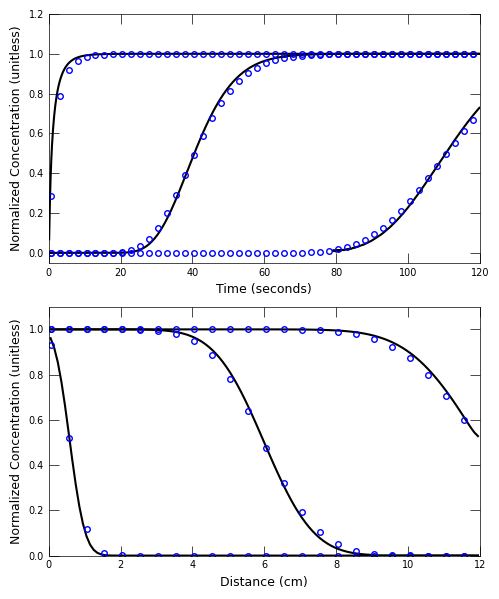

In [33]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    fig, axs = plt.subplots(2, 1, figsize=(5,6), tight_layout=True)

    iskip = 5

    atimes = np.arange(0, tm_par["total_time"], 0.1)
    
    for i, x in enumerate([0.05, 4.05, 11.05]):
        a1, idx_filter = sol_analytical_t(i, x, atimes,mesh, ph_par) 
                
        axs[0].plot(atimes[idx_filter], a1[idx_filter], color="k", label="ANALYTICAL")

        axs[0].plot(simtimes[::iskip], mf6gwt_ra[obsnames[i]][::iskip],
                    marker="o", ls="none", mec="blue", mfc="none", markersize="4",
                    label="MODFLOW 6")
        axs[0].set_ylim(-0.05, 1.2)
        axs[0].set_xlim(0, 120)
        axs[0].set_xlabel("Time (seconds)")
        axs[0].set_ylabel("Normalized Concentration (unitless)")
        
    ctimes = [6.0, 60.0, 120.0]

    
    x, _, _ = mesh.get_coords()
    for i, t in enumerate(ctimes):
        a1, idx_filter = sol_analytical_t(i, x, t, mesh, ph_par, False)
        
        axs[1].plot(x, a1, color="k", label="ANALYTICAL")
        simconc = ucnobj_mf6.get_data(totim=t).flatten()
        axs[1].plot(x[::iskip], simconc[::iskip],
                    marker="o", ls="none", mec="blue", mfc="none", markersize="4",
                    label="MODFLOW 6")
        axs[1].set_ylim(0, 1.1)
        axs[1].set_xlim(0, 12)
        axs[1].set_xlabel("Distance (cm)")
        axs[1].set_ylabel("Normalized Concentration (unitless)")
    
    plt.show()